# Processing of the Ostia Detector Model

In [1]:
import os
import shutil
import numpy as np
import torch
from utils import *
from OstiaDetector import OstiaDetector
from skeleton_to_digraph import ostia_proximity_map, retrieve_ostia_voxel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Device Count: {torch.cuda.device_count()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available: True
CUDA Device Count: 1


## Load the data

In [3]:
# Define the directories containing the files
image_directory = "/data/training_data/"
label_directory = "/data/training_data/"
graph_directory = "/data/training_data/"

# List all the NIfTI files in the directory
image_files = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.endswith('img.nii.gz')]
label_files = [os.path.join(label_directory, f) for f in os.listdir(image_directory) if f.endswith('label.nii.gz')]
graph_files = [os.path.join(graph_directory, f) for f in os.listdir(image_directory) if f.endswith('graph.json')]

In [4]:
# Create a list of dictionnaries with the data, exclude samples with alleged incorrect number of nodes
exclude = ["/data/training_data/102624", "/data/training_data/27badc", "/data/training_data/0604cd", "/data/training_data/26d228", 
           "/data/training_data/04222e", "/data/training_data/22cdd3", "/data/training_data/29db0c", "/data/training_data/0b9189", 
           "/data/training_data/1a42d5", "/data/training_data/1b3c33", "/data/training_data/2f74d6", "/data/training_data/108c99", 
           "/data/training_data/0cce0b", "/data/training_data/064c3e", "/data/training_data/234666", "/data/training_data/28955b", 
           "/data/training_data/0a5b04", "/data/training_data/107165", "/data/training_data/23c591", "/data/training_data/0b06d2",
           "/data/training_data/089ee1", "/data/training_data/18beb4", "/data/training_data/1f594d"]
data = []

for i in image_files:
    if i.split('.')[0] in exclude:
        continue
    for l in label_files:
        for g in graph_files:
            if i.split(image_directory)[1][:6] == l.split(label_directory)[1][:6] == g.split(graph_directory)[1][:6]: # identify the sample
                data += [{'image': i, 'label': l, 'graph': g}]
                break

In [5]:
training, hold_out = data[:-15], data[-15:]

## Model selection

We now have to select the best model out of all the saved models (one per epoch). We have validation losses (on the hold-out set) but those values are not easily interpretable in the scope of the Ostia Detector training. Indeed, the validation losses represent a global difference between the proximity map generated and the ground-truth locations of the ostia but we don't know the distribution of the values in the difference. Thus, we choose the model by comparing the sum of the distances between the predicted locations of the ostia and their ground-truth locations on the hold-out set. The final model is the model that gives the minimal sum.

In [6]:
model_id = "20250330_212645" # timestamp that identifies the model

min_sum_distances = 1000000
epoch_selected = 20 # choose last epoch by default

for epoch_number in range(20, 15, -1): # analyze model from the last epoch to the 16th one
    model_path = "./models/ostia_model_{}_{}".format(model_id, epoch_number)
    
    # Load the model for root nodes detection
    ostia_model = OstiaDetector()
    ostia_model.load_state_dict(torch.load(model_path))
    ostia_model.eval()
    
    # Select the model giving the minimal distance to the ground-truth ostia points
    sum_distances = 0
    for sample in hold_out:        
        _, ostia = load_seeds(sample['image'], sample['graph'])
        proximity_map, affine = ostia_proximity_map(sample['image'], ostia_model, device)
        
        ostia_pred_voxel = retrieve_ostia_voxel(proximity_map, affine)
        
        distances = np.min([np.linalg.norm(ostia_pred_voxel - ostia, axis=1), np.linalg.norm(ostia_pred_voxel - ostia[[1, 0]], axis=1)], axis=0) # we need the minimum value between those two norms because the first term of the prediction can be aligned with the second of the ground truth and vice versa 
        sum_distances += np.sum(distances)                                                                                                       
        
    if sum_distances < min_sum_distances:
        min_sum_distances = sum_distances
        epoch_selected = epoch_number
        
    print("The best model is the one from the {}th epoch".format(epoch_selected))

print("The selected model is the one from the {}th epoch".format(epoch_selected))

The best model is the one from the 20th epoch
The best model is the one from the 20th epoch
The best model is the one from the 20th epoch
The best model is the one from the 20th epoch
The best model is the one from the 16th epoch
The selected model is the one from the 16th epoch


In [7]:
# Rename and place the selected model in the same folder
shutil.copy('./models/ostia_model_{}_{}'.format(model_id, epoch_selected), "./ostia_model_trained")

'./ostia_model_trained'

## Locate the coronary ostia (example with one sample)

In [8]:
model_path = "./ostia_model_trained"
sample = hold_out[0]

In [9]:
image, ostia = load_seeds(sample['image'], sample['graph'])
proximity_map, affine = ostia_proximity_map(sample['image'], ostia_model)
ostia_pred_voxel = retrieve_ostia_voxel(proximity_map, affine)

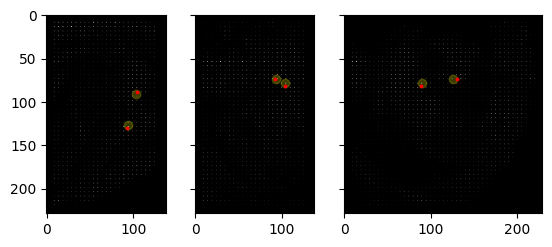

In [10]:
_, axs = plt.subplots(1, 3, width_ratios=[1, 1, image.shape[0]/image.shape[2]], sharey='all')

axs[0].scatter(ostia[:, 2], ostia[:, 1], c="y", alpha=0.3)
axs[0].scatter(ostia_pred_voxel[:, 2], ostia_pred_voxel[:, 1], c="r", s=3)
axs[0].imshow(np.max(proximity_map, axis=0), cmap="gray")
axs[1].scatter(ostia[:, 2], ostia[:, 0], c="y", alpha=0.3)
axs[1].scatter(ostia_pred_voxel[:, 2], ostia_pred_voxel[:, 0], c="r", s=3)
axs[1].imshow(np.max(proximity_map, axis=1), cmap="gray")
axs[2].scatter(ostia[:, 1], ostia[:, 0], c="y", alpha=0.3)
axs[2].scatter(ostia_pred_voxel[:, 1], ostia_pred_voxel[:, 0], c="r", s=3)
axs[2].imshow(np.max(proximity_map, axis=2), cmap="gray")

The red points are the predicted locations of the ostia, the yellow points are the ground-truth locations and the background is the proximity map. The maximum values of the proximity map are in white and even if there are a good amount of them far from the ostia, the prediction is still pretty accurate. Moreover, we can't see the white points on the ostia locations because of the visualizations of the prediction and the ground-truth.